# EPM Moderators of Aging - Simulations

## Notebook Setup

In [1]:
from collections import defaultdict, Counter
import copy
import pkg_resources
from typing import Dict, List, Set, Tuple, Union
import sys

from EPMSim.MethylationSite.SiteGenerator import SiteGenerator
from EPMSim.MethylationSite.ValueGenerator import generate_sample_methylation
from EPMSim.Simulate.SimulateSamples import simulate_samples
from EPMSim.Sample import Sample
from EPMSim.Phenotype import BinaryPhenotype, ContinuousPhenotype, construct_age_association
from EPMSim.Simulate.SimulateSites import GenerateSites

from EpigeneticPacemaker.EpigeneticPacemaker import EpigeneticPacemaker
from EpigeneticPacemaker.EpigeneticPacemakerCV import EpigeneticPacemakerCV
from EPMTrait.DataHandlers import retrieve_sample_methylation
from EPMTrait.ModelHelpers import basic_func, fit_trend, get_age_bins, mae, pearson_correlation, r2
from EPMTrait.Plots import plot_known_predicted

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
from scipy import optimize
import scipy.stats as stats
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf    
from tqdm.notebook import tqdm

### Get Session Environment Information
- notebook environment 
    - Python 3.8.0 (default, Dec  5 2019, 19:17:49) [GCC 9.2.1 20191008]
    - EPMSim 0.0.1
    - EPMTrait 0.0.1
    - EpigeneticPacemaker 0.0.3
    - backcall 0.2.0
    - cffi 1.14.0
    - colorama 0.4.3
    - cycler 0.10.0
    - decorator 4.4.1
    - ipykernel 5.3.0
    - ipywidgets 7.6.3
    - jedi 0.17.2
    - joblib 1.0.1
    - kiwisolver 1.1.0
    - matplotlib 3.4.3
    - numexpr 2.7.1
    - numpy 1.21.1
    - pandas 1.3.1
    - parso 0.7.0
    - patsy 0.5.1
    - pexpect 4.7.0
    - pickleshare 0.7.5
    - pip 21.2.4
    - psutil 5.7.0
    - ptyprocess 0.6.0
    - pyparsing 2.4.5
    - pytz 2019.3
    - scikit-learn 0.24.2
    - scipy 1.4.1
    - seaborn 0.11.1
    - simplejson 3.17.0
    - six 1.15.0
    - statsmodels 0.11.1
    - tornado 6.1
    - tqdm 4.62.2
    - traitlets 4.3.3
    - wcwidth 0.2.4

In [2]:
def get_session_info(import_diff_modules=[]):
    '''
    Retrieve python version and list of imported packages that 
    are imported directly or as dependencies:
        Args:
            import_diff_modules (List[str]): list of modules that have different install and 
                                        import names, ie scikit-learn imported with sklearn
        Returns:
            Dict[str, str]: package_name : version 
    '''
    local_pkgs = {str(i).split()[0]:str(i).split()[1] for i in pkg_resources.working_set}
    session_pkgs = {'Python':sys.version}
    for pkg in sorted(list(set([x.split('.')[0] for x in sys.modules])) + import_diff_modules):
        if pkg in local_pkgs:
            session_pkgs[pkg] = local_pkgs[pkg]
    return session_pkgs

In [3]:
# collect session info
session_info = get_session_info(import_diff_modules=['scikit-learn'])

### Set Plot Characteristics

In [4]:
sns.set(palette="Paired", style='white')
plt.rcParams['legend.title_fontsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.markerscale'] = 2
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['text.usetex'] = True

## Set Simulation Phenotypes

In [5]:
# set trait age assocition for binary phenotype

bp_age_association, bp_repr = construct_age_association(age_weight=.01, age_exponent=0.5, return_repr=True)

In [6]:
pheno_labels = []

In [7]:
pheno_range = 10

In [8]:
# set continuous traits with nonlinear time relationship 

continuous_age_onlys = [ContinuousPhenotype(mean=1.0, std=0.05, age_association=construct_age_association(age_weight=.1, age_exponent=np.random.normal(.5, .1)),
                                          representation=f'continuous_age_only_{x}',
                                          health_effect=False, health_dist=False) for x in range(pheno_range *2)]
pheno_labels.extend([str(x) for x in continuous_age_onlys])

In [9]:
# set continuous traits with linear time relationship 

continuous_lin_age_onlys = [ContinuousPhenotype(mean=1.0, std=0.05, age_association=construct_age_association(age_weight=.1, age_exponent=np.random.normal(1, .1)),
                                          representation=f'continuous_age_only_lin_{x}',
                                          health_effect=False, health_dist=False) for x in range(pheno_range * 2)]
pheno_labels.extend([str(x) for x in continuous_lin_age_onlys])

In [10]:
# continuous linear traits influenced by sample health and age

continuous_age_lin = [ContinuousPhenotype(mean=1.0, std=0.01, age_association=construct_age_association(age_weight=.1, age_exponent=np.random.normal(1, .1)),
                                          representation=f'continuous_lin_{x}',
                                          health_effect=True, health_dist=True) for x in range(pheno_range)]
pheno_labels.extend([str(x) for x in continuous_age_lin])

In [11]:
# continuous nonlinear traits influenced by sample health and age

continuous_emps = [ContinuousPhenotype(mean=1, std=0.01, age_association=construct_age_association(age_weight=.1, age_exponent=np.random.normal(0.5, .1)),
                                          representation=f'continuous_emp_{x}',
                                          health_effect=True, health_dist=True) for x in range(pheno_range)]
pheno_labels.extend([str(x) for x in continuous_emps])

In [12]:
# set std for contiuous trait sampling at binary mean of 0.995
cont_assess_ranges = [0.00025, 0.0005, 0.001, 0.0015, 0.002]

In [13]:
binary_phenotypes = {}

for mean in np.linspace(.995, 1.00, 5):
    for count in range(50):
        contin_trait_range = list(np.linspace(0, 0.01, 5)) +  cont_assess_ranges if mean == 0.995 else list(np.linspace(0, 0.01, 5))
        for contin_trait in contin_trait_range:
            label = f'bin_cat_decrease'
            bp = BinaryPhenotype(mean=mean, std=0.0, binary_prob=0.5,
                                 age_association=bp_age_association,
                                 representation=label,
                                 health_dist=False, health_effect=True
                                 )
            binary_phenotypes[f'{label}_{mean}_{count}_{contin_trait}'] = [bp, contin_trait]

### Plot Toy Simulation Example

In [14]:
sim_conditions = [dict(age_weight=.1, age_exponent=.5, exponent_std=0.1),
                  dict(age_weight=.1, age_exponent=1, exponent_std=0.1)]

In [15]:
def get_expected_state(ages, q=1, age_weight=1, age_exponent=1):
    expected = (ages ** age_exponent * age_weight * q)
    return expected / max(expected)

$p_{k,j} = Age_j^{\mathcal{N}(0.5, 0.01)} q_{k,j}$
$p_{k,j} = Age_j^{\mathcal{N}(1, 0.01)} q_{k,j}$


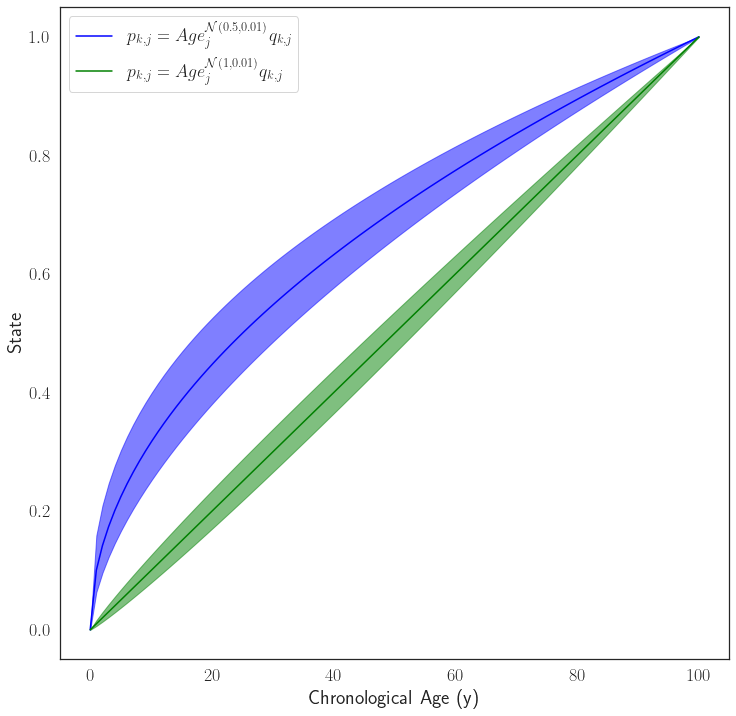

In [16]:
fig, ax = plt.subplots(figsize=(12,12))

colors = ['b', 'g', 'r', 'y']

for count, sim in enumerate(sim_conditions):
    example_ages = np.linspace(0,100, 100)
    exp_1 = get_expected_state(example_ages, age_exponent=sim['age_exponent'] - sim['exponent_std'])
    exp_2 = get_expected_state(example_ages, age_exponent=sim['age_exponent'])
    exp_3 = get_expected_state(example_ages, age_exponent=sim['age_exponent'] + sim['exponent_std'])
    ax.plot(example_ages, exp_1, color=colors[count], alpha=0.0)
    ax.plot(example_ages, exp_2, color=colors[count],
            label=f'$p_{{k,j}} = Age_j^{{\\mathcal{{N}}({sim["age_exponent"]}, 0.01)}} q_{{k,j}}$')
    print(str(f'$p_{{k,j}} = Age_j^{{\\mathcal{{N}}({sim["age_exponent"]}, 0.01)}} q_{{k,j}}$'))
    ax.plot(example_ages, exp_3, color=colors[count], alpha=0.0)
    ax.fill_between(example_ages, exp_1, exp_3, color=colors[count], alpha=0.5)
    
ax.set_xlabel('Chronological Age (y)')
ax.set_ylabel('State')
plt.legend()
plt.savefig('figures/Figure1.png', dpi=200, bbox_inches='tight')
plt.show()

### Simulate Sites and Sample Methylation

In [17]:
phenotype_systems = {label: [bp[0]] + continuous_age_onlys + continuous_age_lin + continuous_emps + continuous_lin_age_onlys for label, bp in binary_phenotypes.items()}

In [18]:
first_condition_labels = [str(pheno) for pheno in phenotype_systems[list(phenotype_systems.keys())[0]]]
conditions = {count: [[str(pheno)], 5] for count, pheno in enumerate(first_condition_labels)}
for x in range(pheno_range):
    conditions[len(conditions) + 1] = [[f'continuous_emp_{x}', 'bin_cat_decrease', f'continuous_age_only_lin_{x}', f'continuous_age_only_{x}', f'continuous_lin_{x}'], 5]
conditions[0] = [['bin_cat_decrease'], 100]
site_gen = GenerateSites(site_conditions=conditions, noise_sites=0)
site_gen.generate_sites()

In [19]:
len(site_gen.sites)

450

In [20]:
age_sites = [count for count, site in enumerate(site_gen.sites) if any(['continuous_age_only' in site['site_phenotypes'][0] or 'continuous_age_only_lin' in site['site_phenotypes'][0]]) and len(site['site_phenotypes']) == 1]

In [21]:
binary_sites = [count for count, site in enumerate(site_gen.sites) if site['site_phenotypes'][0] == 'bin_cat_decrease' and len(site['site_phenotypes']) < 2]

In [22]:
continuous_sites = [count for count, site in enumerate(site_gen.sites) if any(['continuous_lin_' in site['site_phenotypes'][0] or 'continuous_emp' in site['site_phenotypes'][0]]) and len(site['site_phenotypes']) == 1]

In [23]:
mixed_sites = [count for count, site in enumerate(site_gen.sites) if len(site['site_phenotypes']) > 1]

In [24]:
def gen_sim_samples(bp, ps, health_variation=0.01, sample_count=1000):
    return bp, simulate_samples(phenotypes=ps, health_variation=health_variation, 
                                sample_count=sample_count, 
                                epigenetic_state=lambda x: 10.0 * x**0.5)

In [25]:
bp_samples = joblib.Parallel(n_jobs=16, verbose=1)(joblib.delayed(gen_sim_samples)(*[label, phenotype_systems[label], 
                                                                                      binary_phenotypes[label][1], 500]) for label in phenotype_systems)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   13.4s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:   31.5s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:   57.5s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:  1.5min
[Parallel(n_jobs=16)]: Done 1500 out of 1500 | elapsed:  1.8min finished


In [26]:
bp_samples = {x[0]: x[1] for x in bp_samples}

In [27]:
def gen_sites(bp, site_gen, samples):
    meth_values, meth_errors = site_gen.generate_sample_methylation(samples)
    return bp, dict(meth_values=meth_values, meth_errors=meth_errors)

In [28]:
generated_sites = joblib.Parallel(n_jobs=16, verbose=1)(joblib.delayed(gen_sites)(*[bp, site_gen, bp_samples[bp]]) for bp in phenotype_systems)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.1s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   26.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.1min
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.0min
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:  3.4min
[Parallel(n_jobs=16)]: Done 1500 out of 1500 | elapsed:  4.6min finished


In [29]:
generated_sites = {sites[0]: sites[1] for sites in generated_sites}

### Process Simulated Traits 

In [30]:
def construct_phenotype_matrix(samples):
    sample_phenotypes = {}
    for sample, sample_info in samples.items():
        pheno = {trait_label: trait.trait_value for trait_label, trait in sample_info.phenotypes.items()}
        pheno.update({f'{trait_label}_has_trait': trait.has_trait for trait_label, trait in sample_info.phenotypes.items()})
        pheno['age'] = sample_info.age
        pheno['ageSqrt'] = np.sqrt(sample_info.age)
        pheno['state'] = sample_info.epigenetic_state
        pheno['expected_state'] = sample_info.expected_epigenetic_state
        pheno['continuous'] = sample_info.health
        sample_phenotypes[sample] = pheno
    return pd.DataFrame(sample_phenotypes).T

In [31]:
def add_bin(phenotype_df):
    bin_cat = [cat for cat in list(phenotype_df) if 'bin_cat_decrease' in cat]
    bin_values = [1 if value else 0 for value in phenotype_df[f'{bin_cat[0]}_has_trait'].values]
    phenotype_df['bin'] = np.array(bin_values)

In [32]:
for bp, b_samples in tqdm(bp_samples.items()):
    df = construct_phenotype_matrix(b_samples) 
    add_bin(df)
    generated_sites[bp]['phenotype_df'] = df

  0%|          | 0/1500 [00:00<?, ?it/s]

### Fit EPM and LM Models for Simulated Datasets

In [33]:
# set train, test indices to used across all simulations 
train_samples, test_samples = train_test_split(np.array(list(bp_samples[list(bp_samples.keys())[0]].keys())), test_size=0.5)

In [34]:
def clean_results(epm, popt, phenotypes,
                  train_samples, train_states, train_expected,
                  test_samples, test_states, test_expected,
                  lm, train_ea, test_ea,
                  train_ea_diff, test_ea_diff):
    sample_results = phenotypes.T.to_dict()
    for sample, state, expected, ea, ea_diff in zip(train_samples, train_states, train_expected, train_ea, train_ea_diff):
        sample_results[sample].update({'status':'train', 'state':state, 'expected': expected,
                                       'diff':state - expected, 'ea':ea, 'ea_diff':ea_diff})
    for sample, state, expected, ea, ea_diff in zip(test_samples, test_states, test_expected, test_ea, test_ea_diff):
        sample_results[sample].update({'status':'test', 'state':state, 'expected': expected,
                                       'diff': state - expected, 'ea': ea, 'ea_diff': ea_diff})
    return dict(sample_results=sample_results, model=epm, popt=popt, lm=lm, 
                train_r2=r2(train_states, train_expected), test_r2=r2(test_states, test_expected),
                train_ma2=mae(train_states, train_expected), test_mae=mae(test_states, test_expected))

In [35]:
def fit_epm(values, ages) -> Tuple[EpigeneticPacemaker, np.ndarray]:
    # initialize and fit EPM 
    epm = EpigeneticPacemaker()
    epm.fit(values, ages)
    states = epm.predict(values)
    return epm, states

In [36]:
def fit_lm(values, ages, en_kwargs):
    ## initialize and fit penalized regression model
    lm = ElasticNet(**en_kwargs)
    lm.fit(values.T, ages)
    predicted = lm.predict(values.T)
    return lm, predicted

In [37]:
default_en_kwargs = dict(alpha=1.0, l1_ratio=0.75, fit_intercept=True, normalize=False, precompute=False, max_iter=100, copy_X=True, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='random')

In [38]:
def process_sim_exp(exp_id, exp_info, _train_samples, _test_samples, matrix_sites=None, en_kwargs=None):
    matrix, phenotypes = exp_info['meth_values'], exp_info['phenotype_df']
    if matrix_sites:
        meth_matrix = matrix[matrix_sites, :]
    else:
        meth_matrix = matrix
        
    # subset matrix
    train_matrix, test_matrix = meth_matrix[:, _train_samples], meth_matrix[:, _test_samples]
    train_ages, test_ages = phenotypes.loc[_train_samples]['age'].values, phenotypes.loc[_test_samples]['age'].values
       
    # train epm
    epm, train_states = fit_epm(train_matrix, train_ages)
    popt, _, train_expected = fit_trend(train_ages, train_states, func=basic_func)

    
    # train en
    lm, train_ea = fit_lm(train_matrix, train_ages, en_kwargs)
    lm_sites = np.array([count for count, coef in enumerate(lm.coef_) if coef])
    train_ea_diff = train_ages - train_ea

    # get test predictions
    test_states = epm.predict(test_matrix)
    test_expected = basic_func(test_ages, *popt)
    test_ea = lm.predict(test_matrix.T)
    test_ea_diff = test_ea - test_ages
    
    res = clean_results(epm, popt, phenotypes,
                        _train_samples, train_states, train_expected,
                        _test_samples, test_states, test_expected,
                        lm, train_ea, test_ea, train_ea_diff, test_ea_diff)
    res.update(dict(lm_train_r2=r2(train_ea, train_ages), lm_train_mae=mae(train_ea, train_ages),
                    lm_test_r2=r2(test_ea, test_ages), lm_test_mae=mae(test_ea, test_ages),
                    lm_sites=lm_sites))
    return exp_id, res

In [39]:
# format sim exps for processing

exp_runs = []

for bp, exp_info, in generated_sites.items():
    bp_health_std = float(bp.split('_')[-1])
    if bp_health_std in cont_assess_ranges:
        continue
    else:
        exp_runs.append([bp, copy.deepcopy(exp_info), train_samples, test_samples, None, default_en_kwargs])

In [40]:
exp_results = joblib.Parallel(n_jobs=16, verbose=1)(joblib.delayed(process_sim_exp)(*exp) for exp in exp_runs)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  19 tasks      | elapsed:    8.9s
[Parallel(n_jobs=16)]: Done 169 tasks      | elapsed:   14.3s
[Parallel(n_jobs=16)]: Done 419 tasks      | elapsed:   23.8s
[Parallel(n_jobs=16)]: Done 769 tasks      | elapsed:   39.0s
[Parallel(n_jobs=16)]: Done 1219 tasks      | elapsed:  1.0min
[Parallel(n_jobs=16)]: Done 1250 out of 1250 | elapsed:  1.0min finished


In [41]:
site_proportions = [((10 - count) * 5, count * 5) for count in range(6)]
prop_cat = 'bin_cat_decrease_0.995'

In [42]:
# collect all sim exps with varried continuous std

contin_runs = []

for bp, exp_info, in generated_sites.items():
    bp_health_std = float(bp.split('_')[-1])
    if prop_cat in bp:
        contin_runs.append([bp, copy.deepcopy(exp_info), train_samples, test_samples, None, default_en_kwargs])

In [43]:
contin_results = joblib.Parallel(n_jobs=16, verbose=1)(joblib.delayed(process_sim_exp)(*exp) for exp in contin_runs)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    3.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    9.1s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:   10.9s finished


### Fit LM to check for detectable associations

In [44]:
site_labels = [site['site_phenotypes'][0] if len(site['site_phenotypes']) == 1 else 'Mixed' for site in site_gen.sites]
site_labels = [site if 'continuous' not in site else '_'.join(site.split('_')[0:-1]) for site in site_labels]

In [45]:
def get_design_matrices(y_cat=None, x_cats=[], exp_df=None, fit_intercept=False):
    intercept = ' + 0' if not fit_intercept else ''
    r_df = exp_df[[y_cat] + x_cats]
    r_df = r_df.astype('float')
    xs = ' + '.join(x_cats)
    y, X = dmatrices(f'{y_cat} ~ {xs}{intercept}', data=r_df, return_type='dataframe')
    return y, X

In [46]:
def format_res(res):
    results = []
    for key, value in res.summary2().tables[1].T.to_dict().items():
        for x in ['Coef.', 'Std.Err.', 't', 'P>|t|']:
            results.append(value[x])
    for x in res.summary2().tables[0].values:
        for y in range(int(len(x) / 2)):
            #model_info[x[y * 2]] = x[y * 2 + 1]
            results.append(x[y * 2 + 1])
    for x in res.summary2().tables[2].values:
        for y in range(int(len(x) / 2)):
            #model_info[x[y * 2]] = x[y * 2 + 1]
            results.append(x[y * 2 + 1])
    return results

In [47]:
def fit_exp_model(y_cat=None, exp_df=None, fit_intercept=True):
    x_cats = ['age', 'bin', 'continuous', 'ageSqrt']
    y, X = get_design_matrices(y_cat, x_cats, exp_df, fit_intercept=fit_intercept)
    results = sm.OLS(y, X).fit()
    return format_res(results)

In [48]:
def assess_sm_models(exp_df, fit_intercept=True):
    epm_res = fit_exp_model(y_cat='state', exp_df=exp_df, fit_intercept=fit_intercept)
    lm_res = fit_exp_model(y_cat='ea', exp_df=exp_df, fit_intercept=fit_intercept)
    return epm_res + lm_res

In [49]:
def split_label(label, label_type=None):
    label_split = label.split('_')
    new_label = '_'.join(label_split[0:-3])
    q = float(label_split[3]) 
    formatted_q = f'{float(q): .3f}'
    count = int(label_split[4])
    con_std = float(label_split[5])
    if label_type == 'prop':
        a_sites = int(label_split[-2])
        b_sites = int(label_split[-1]) 
        age_site_prop = a_sites / (a_sites + b_sites)
        return [q, formatted_q, age_site_prop, f'{age_site_prop:.1f}', count, con_std]
    elif label_type == 'number':
        sample_number = int(label_split[-1])
        return [q, formatted_q, sample_number, count, con_std]
    return [q, formatted_q, count, con_std]

In [50]:
def get_exp_assoc(exp, label_type=None):
    exp_label = split_label(exp[0], label_type)    
    exp_info = pd.DataFrame(exp[1]['sample_results']).T

    exp_sm_res = assess_sm_models(exp_info)
    
    return exp_label + exp_sm_res 

In [51]:
exp_sm_stats = joblib.Parallel(n_jobs=16, verbose=1)(joblib.delayed(get_exp_assoc)(*[exp, None]) for exp in exp_results)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    3.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    7.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:   11.5s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:   17.1s
[Parallel(n_jobs=16)]: Done 1250 out of 1250 | elapsed:   17.4s finished


In [52]:
contin_sm_stats = joblib.Parallel(n_jobs=16, verbose=1)(joblib.delayed(get_exp_assoc)(*[exp, None]) for exp in contin_results)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 304 tasks      | elapsed:    3.8s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    6.2s finished


### Clean and Plot results

In [53]:
def get_sm_header(x_cats=['intercept', 'age', 'bin', 'continuous', 'ageSqrt'], comp_type=None):
    left = ['q', 'formattedQ', 'count', 'Continuous STD']
    if comp_type == 'prop':
        left = ['q', 'formattedQ', 'ageSiteProp', 'formattedAgeSiteProp', 'count', 'Continuous STD']
    elif comp_type == 'number':
        left = ['q', 'formattedQ', 'sampleNumber', 'count', 'Continuous STD']
    model_params = ['Model:','Adj. R-squared:','Dependent Variable:',
             'AIC:','Date:','BIC:','No. Observations:',
             'Log-Likelihood:','Df Model:','F-statistic:',
             'Df Residuals:','Prob (F-statistic):',
             'R-squared:','Scale:',
             'Omnibus:','Durbin-Watson:','Prob(Omnibus):',
             'Jarque-Bera (JB):','Skew:',
             'Prob(JB):','Kurtosis:','Condition No.:']
    coef_cats = ['Coef.', 'Std.Err.', 't', 'P']
    middle = []
    for model in ['epm', 'lm']:
        for cat in x_cats:
            for coef_cat in coef_cats:
                middle.append(f'{model}-{cat}-{coef_cat}')
        middle.extend([f'{model}-{x}' for x in model_params])
    return left + middle

In [54]:
def get_lm_count_header(site_labels, comp_type=None):
    left = ['q', 'formattedQ', 'count', 'Continuous STD']
    if comp_type == 'prop':
        left = ['q', 'formattedQ', 'ageSiteProp', 'formattedAgeSiteProp', 'count', 'Continuous STD']
    elif comp_type == 'number':
        left = ['q', 'formattedQ', 'sampleNumber', 'count', 'Continuous STD']
    return left + sorted(list(set(site_labels)))

In [55]:
exp_sm_stats_df = pd.DataFrame(exp_sm_stats, columns=get_sm_header())

In [56]:
contin_sm_stats_df = pd.DataFrame(contin_sm_stats, columns=get_sm_header())

In [57]:
np.mean(exp_sm_stats_df.loc[exp_sm_stats_df['formattedQ'] == ' 0.995']['epm-bin-P'].values), np.std(exp_sm_stats_df.loc[exp_sm_stats_df['formattedQ'] == ' 0.995']['epm-bin-P'].values)

(0.03520314939834487, 0.089602954476278)

In [58]:
np.mean(exp_sm_stats_df.loc[exp_sm_stats_df['formattedQ'] == ' 0.995']['lm-bin-P'].values), np.std(exp_sm_stats_df.loc[exp_sm_stats_df['formattedQ'] == ' 0.995']['lm-bin-P'].values)

(0.269436930948381, 0.2827964574290169)

In [59]:
np.mean(contin_sm_stats_df.loc[contin_sm_stats_df['Continuous STD'] == 0.0025]['epm-continuous-P']), np.std(contin_sm_stats_df.loc[contin_sm_stats_df['Continuous STD'] == 0.0025]['epm-continuous-P'])

(0.01944110687557254, 0.0436109264008506)

In [60]:
np.mean(contin_sm_stats_df.loc[contin_sm_stats_df['Continuous STD'] == 0.0025]['lm-continuous-P']), np.std(contin_sm_stats_df.loc[contin_sm_stats_df['Continuous STD'] == 0.0025]['lm-continuous-P'])

(0.06072307856814105, 0.1287629506508145)

### Figure 1

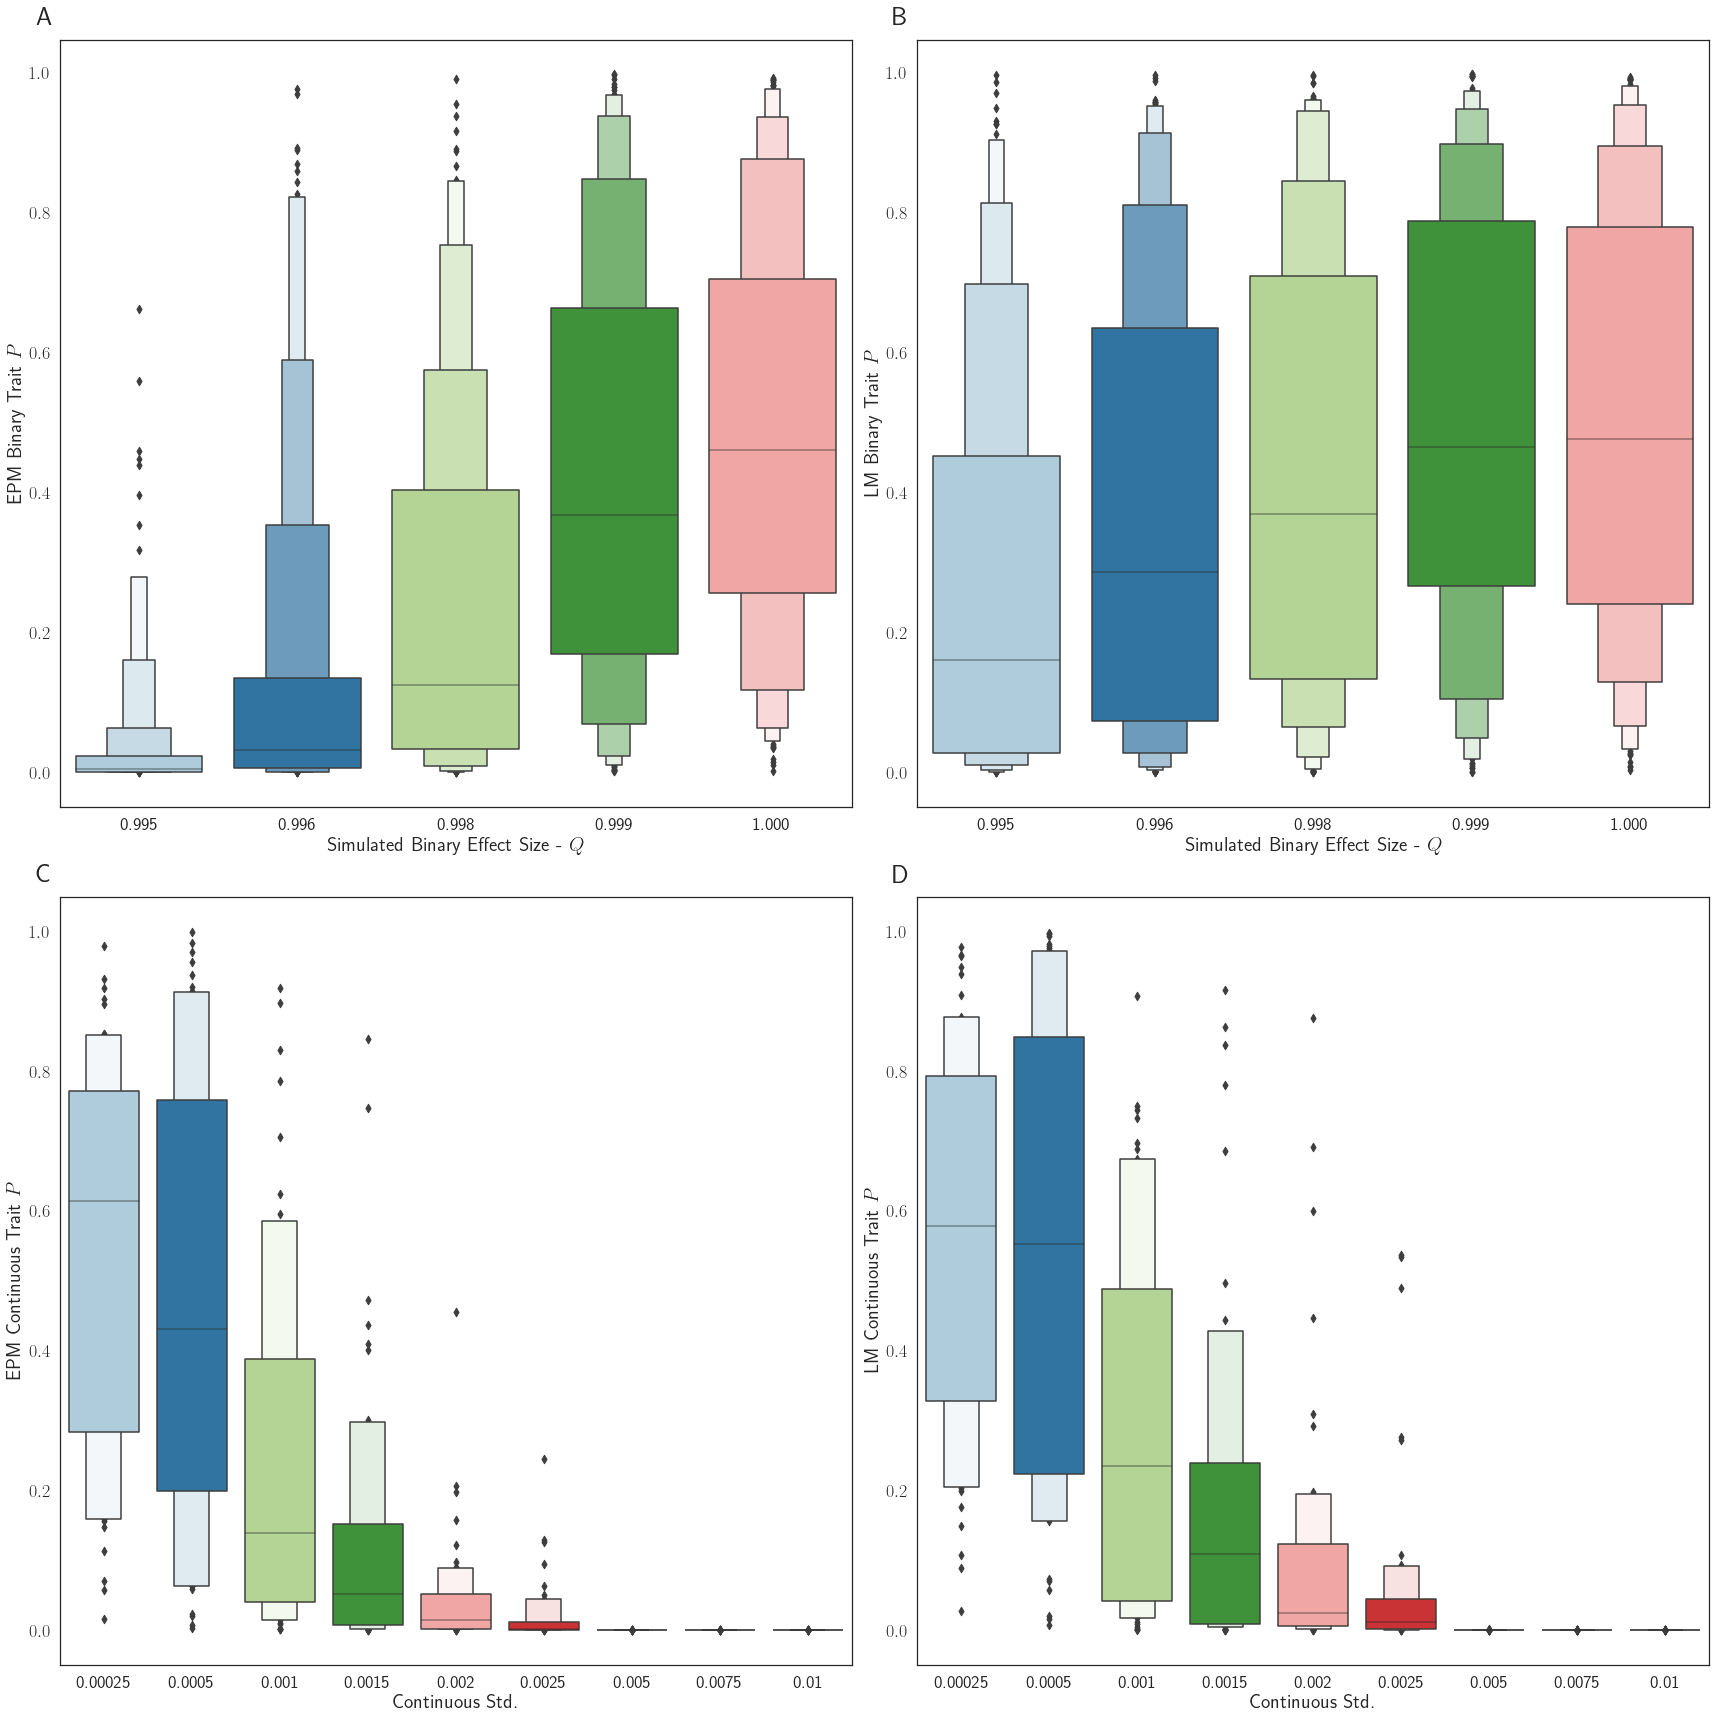

In [61]:
fig, ax = plt.subplots(2, 2, figsize=(24,24))

sns.boxenplot(x='formattedQ', y='epm-bin-P', ax=ax[0, 0], data=exp_sm_stats_df)
ax[0,1].set_ylim(ax[0,0].get_ylim())
sns.boxenplot(x='formattedQ', y='lm-bin-P', ax=ax[0, 1], data=exp_sm_stats_df)

ax[0,0].set_xlabel('Simulated Binary Effect Size - $Q$')
ax[0,1].set_xlabel('Simulated Binary Effect Size - $Q$')

ax[0,0].set_ylabel('EPM Binary Trait $P$')
ax[0,1].set_ylabel('LM Binary Trait $P$')

sns.boxenplot(x='Continuous STD', y='epm-continuous-P', ax=ax[1, 0], data=contin_sm_stats_df.loc[contin_sm_stats_df['Continuous STD'] != 0.0])
ax[1,1].set_ylim(ax[1,0].get_ylim())
sns.boxenplot(x='Continuous STD', y='lm-continuous-P', ax=ax[1, 1], data=contin_sm_stats_df.loc[contin_sm_stats_df['Continuous STD'] != 0.0])

ax[1,0].set_xlabel('Continuous Std.')
ax[1,1].set_xlabel('Continuous Std.')
ax[1,0].set_ylabel('EPM Continuous Trait $P$')
ax[1,1].set_ylabel('LM Continuous Trait $P$')

ax[0,0].text(-0.03, 1.02, f'A', transform=ax[0,0].transAxes, fontsize=26, weight='bold')
ax[0,1].text(-0.03, 1.02, f'B', transform=ax[0,1].transAxes, fontsize=26, weight='bold')
ax[1,0].text(-0.03, 1.02, f'C', transform=ax[1,0].transAxes, fontsize=26, weight='bold')
ax[1,1].text(-0.03, 1.02, f'D', transform=ax[1,1].transAxes, fontsize=26, weight='bold')


plt.tight_layout()
plt.savefig('figures/Figure2.png', dpi=300)